# **Descriptive Analytics**

In [69]:
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np

In [70]:
try:
    df = pd.read_pickle('resources/pickle_files/charging_sessions_prepared.pkl')
    print("Successfully imported charging_sessions.csv")
except FileNotFoundError:
    print("Error: charging_sessions.csv not found.")

Successfully imported charging_sessions.csv


In [71]:
df

,connectionTime,connectionDuration,chargingDuration,kWhDelivered,siteID,userID,minutesAvailable,kWhRequested,WhPerMile,dayOfWeek,month,isHoliday,isPandemic
0,2020-01-02 05:08:54-08:00,6.039167,4.378056,25.016,1,194.0,463.0,25.00,250.0,Thursday,January,False,False
1,2020-01-02 05:36:50-08:00,9.025278,6.687500,33.097,1,4275.0,595.0,70.00,280.0,Thursday,January,False,False
2,2020-01-02 05:56:35-08:00,10.713056,2.641944,6.521,1,344.0,60.0,8.00,400.0,Thursday,January,False,False
3,2020-01-02 05:59:58-08:00,2.644722,1.313056,2.355,1,1117.0,65.0,8.00,400.0,Thursday,January,False,False
4,2020-01-02 06:00:01-08:00,8.144167,4.291389,13.375,1,334.0,504.0,16.00,400.0,Thursday,January,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65032,2019-07-01 14:49:12-07:00,3.801667,1.422500,8.399,1,1346.0,36.0,32.00,400.0,Monday,July,False,False
65033,2019-07-01 14:58:45-07:00,2.684167,2.693333,16.864,1,364.0,234.0,40.00,400.0,Monday,July,False,False
65034,2019-07-01 15:02:21-07:00,2.941389,2.950556,18.335,1,2050.0,309.0,29.97,333.0,Monday,July,False,False
65035,2019-07-01 15:23:44-07:00,3.664444,3.672778,22.815,1,1626.0,99.0,34.00,200.0,Monday,July,False,False


## **Temporal Patterns and Seasonality**

After having prepared the data for further use, we want to analyze how the number of charging events varies during the day, the week, and between seasons.

### **Variation during the day**

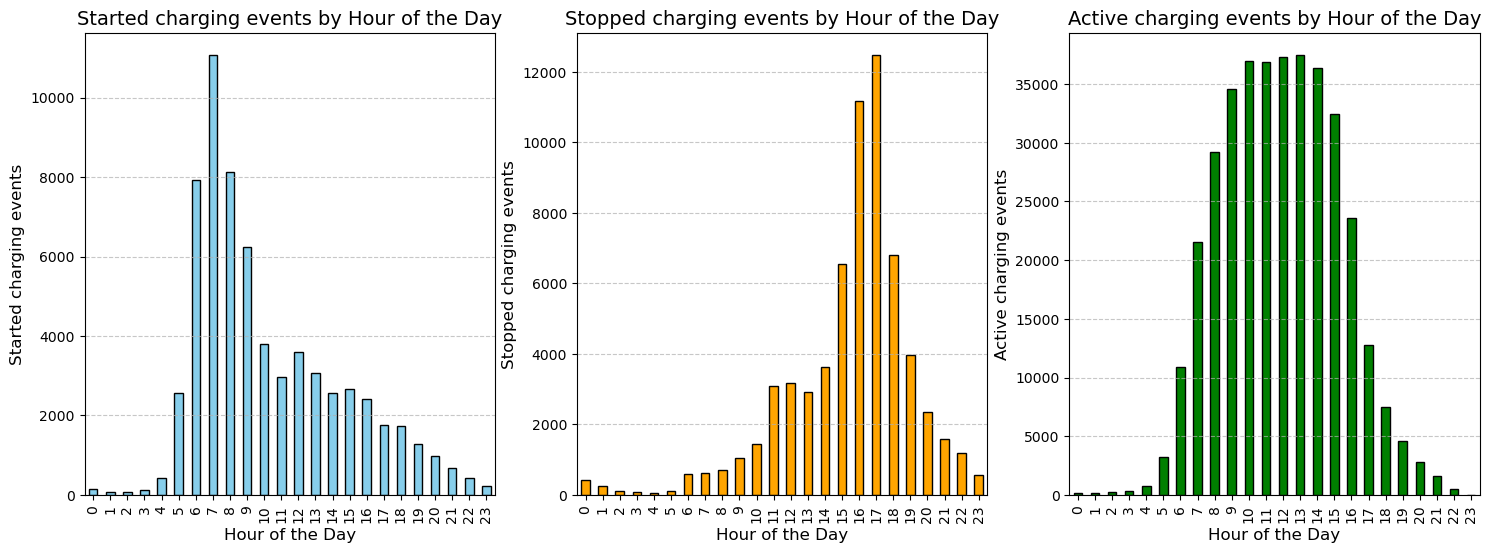

In [72]:
df['connectionHour'] = df['connectionTime'].dt.hour
hourly_connection_counts = df.groupby('connectionHour').size()
df['disconnectHour'] = (df['connectionTime'] + pd.to_timedelta(df['connectionDuration'], unit='h')).dt.hour
hourly_disconnect_counts = df.groupby('disconnectHour').size()

hours = np.arange(24)
active_sessions = []
for hour in hours:
    active_count = ((df['connectionHour'] <= hour) & (df['disconnectHour'] > hour)).sum()
    active_sessions.append(active_count)

active_sessions_series = pd.Series(active_sessions, index=hours)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

hourly_connection_counts.plot(kind='bar', color='skyblue', edgecolor='black', ax=axes[0])
axes[0].set_title('Started charging events by Hour of the Day', fontsize=14)
axes[0].set_xlabel('Hour of the Day', fontsize=12)
axes[0].set_ylabel('Started charging events', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

hourly_disconnect_counts.plot(kind='bar', color='orange', edgecolor='black', ax=axes[1])
axes[1].set_title('Stopped charging events by Hour of the Day', fontsize=14)
axes[1].set_xlabel('Hour of the Day', fontsize=12)
axes[1].set_ylabel('Stopped charging events', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

active_sessions_series.plot(kind='bar', color='green', edgecolor='black', ax=axes[2])
axes[2].set_title('Active charging events by Hour of the Day', fontsize=14)
axes[2].set_xlabel('Hour of the Day', fontsize=12)
axes[2].set_ylabel('Active charging events', fontsize=12)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

As we can see in the figure above, the majority of the charging sessions are started in early hours of the day (6am-8am). We can explain this with most peoples 
schedule being that they arrive at work / uni in the morning. They would then leave their car for charging and go on with their day. Less and less people arrive at the sites then later in the day, which is why the amount of chargings declines. Similarly, most charging sessions end around 4pm-5pm, where most people finish their work day / uni and head home.

### **Variation during the week**

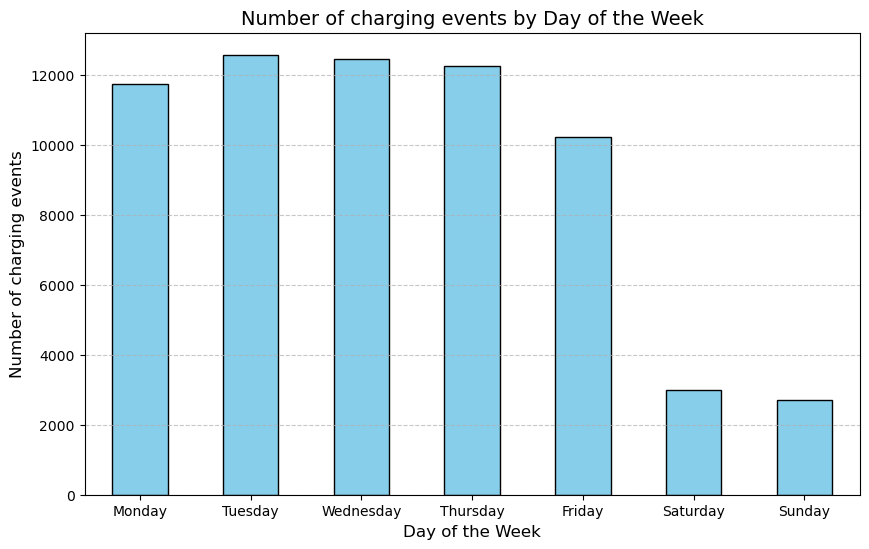

In [73]:
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df['dayOfWeek'] = pd.Categorical(df['dayOfWeek'], categories=day_order, ordered=True)
weekly_counts = df.groupby('dayOfWeek', observed=True).size()

plt.figure(figsize=(10, 6))
weekly_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of charging events by Day of the Week', fontsize=14)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Number of charging events', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

We see that the amounts of charging events remain mostly stable during the working week, with slightly lower values on Monday and Friday. This could be caused by the fact that people prefer working from home right before / after the weekend or some students prefer to stay at home instead of using their car to get to work / uni. Further, we see a massive drop in the values on Saturday and Sunday. A reason for this could be that most people don't have to commute to work / university / school and just stay at home on the weekend without using their cars.

### **Variation between Seasons**

Now we want to inspect the variation between the different seasons. In order to have comparable results, we will restrict ourselves on the year 2019. With this approach, every season is completely included once and we avoid the sudden change caused by Covid.

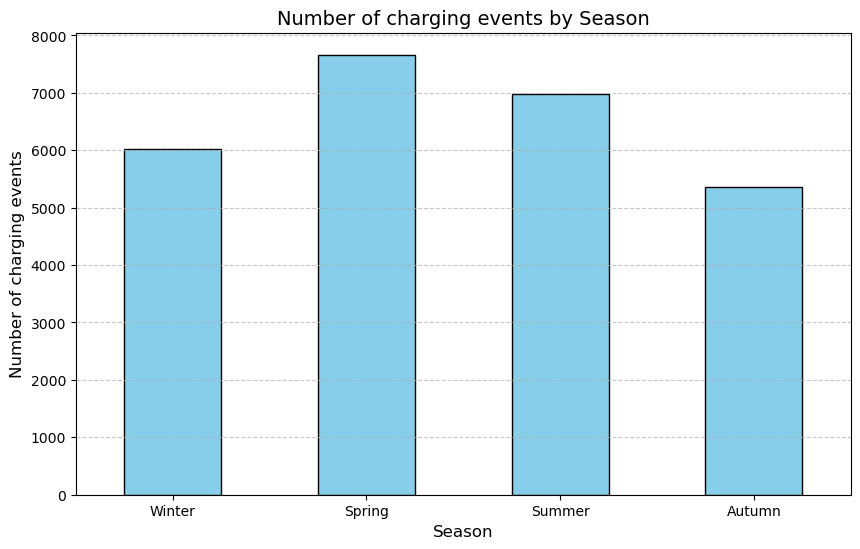

In [74]:
def get_season(date):
    if (date.month == 12 and date.day >= 21) or date.month in [1, 2] or (date.month == 3 and date.day <= 19):
        return 'Winter'
    elif (date.month == 3 and date.day >= 20) or date.month in [4, 5] or (date.month == 6 and date.day <= 20):
        return 'Spring'
    elif (date.month == 6 and date.day >= 21) or date.month in [7, 8] or (date.month == 9 and date.day <= 21):
        return 'Summer'
    elif (date.month == 9 and date.day >= 22) or date.month in [10, 11] or (date.month == 12 and date.day <= 20):
        return 'Autumn'


df_2019 = df[df['connectionTime'].between('2019-01', '2019-12')].copy(deep=True)
df_2019['season'] = df_2019['connectionTime'].apply(get_season)
seasonal_counts = df_2019['season'].value_counts()
seasonal_counts = seasonal_counts.reindex(['Winter', 'Spring', 'Summer', 'Autumn'], fill_value=0)

plt.figure(figsize=(10, 6))
seasonal_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of charging events by Season', fontsize=14)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Number of charging events', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

We observe that the most charging events happen in Spring, followed by Summer. An explanation could be that people perceive the weather as 'nicer' and warmer in those seasons and are more willing to go outside, go on trips and go on vacation, which is why they use their cars more often. In contrast, the weather in Autumn and Winter might be perceived as colder and worse, which is why people would prefer staying at home and not use their car.

## **Key Performance Indicators**

We have chosen the following **Key Performance Indicators**

1. **Active Sessions**
- The number of charging sessions currently active
- This KPI gives us an immediate overview of how many charging sessions are happening at the same time, thus giving us an insight into the hub’s utilization. A consistently high number of active sessions means a high demand, while a low count might hint at underutilization. Monitoring this could help the operator identify peak usage times and optimize resources

2. **Delivered Energy**
- The kWh delivered per hour
- This KPI shows us the direct energy consumption of all charging sessions at a given point of time. This gives a direct insight into the hub's utilization.

3. **Requested Energy**
- The kWh requested by the users per hour
- This KPI visualizes the direct energy demand of the users, giving us an understanding of the users needs. A strongly rising graph shows an increasing demand, while a slow falling graph means low demand

<Figure size 1000x600 with 0 Axes>

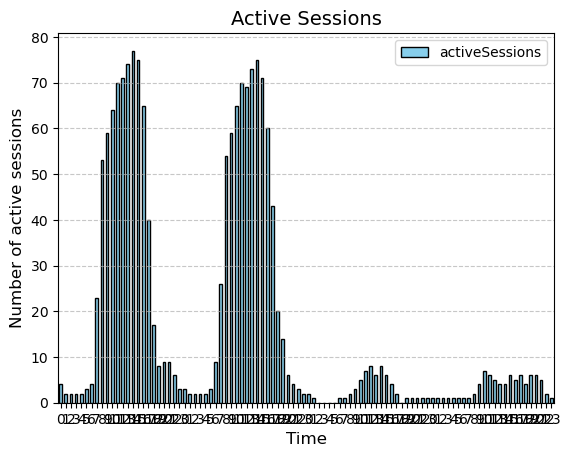

<Figure size 1000x600 with 0 Axes>

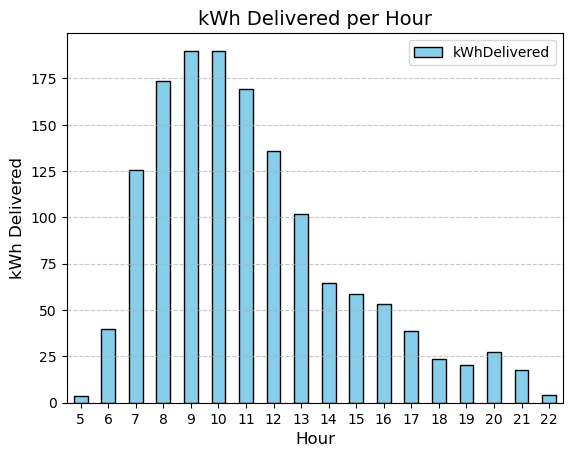

<Figure size 1000x600 with 0 Axes>

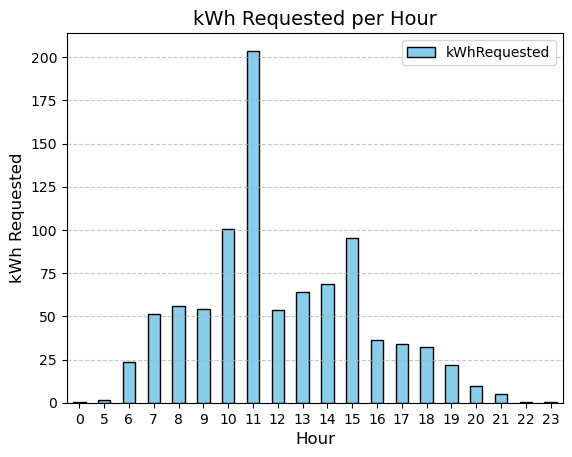

In [80]:
kpi_df = df.copy()
time_range = pd.date_range('2019-01-01 00:00:00', '2019-01-31 23:59:59', freq='h', tz='America/Los_Angeles')
kpi_df = kpi_df[
    (kpi_df['connectionTime'] + pd.to_timedelta(kpi_df['connectionDuration'], unit='h') <= time_range[-1]) &
    (kpi_df['connectionTime'] >= time_range[0])]


active_sessions = []
for time_point in time_range:
    active_count = kpi_df[
        (kpi_df['connectionTime'] <= time_point) &
        (kpi_df['connectionTime'] + pd.to_timedelta(kpi_df['connectionDuration'], unit='h') > time_point)
    ].shape[0]
    active_sessions.append(active_count)


active_sessions_df = pd.DataFrame({
    'time': time_range,
    'hour': time_range.hour,
    'activeSessions': active_sessions,
})


def distribute_kwh_hourly_with_site(df):
    df['end_time'] = df['connectionTime'] + pd.to_timedelta(df['chargingDuration'], unit='h')
    df['kWhRequested_per_hour'] = df['kWhRequested'] / (df['minutesAvailable'] / 60)
    df['intervals'] = df.apply(
        lambda row: pd.date_range(
            start=row['connectionTime'],
            end=row['end_time'],
            freq='5min',
            inclusive='left',
            ambiguous=True
        ),
        axis=1
    )
    exploded_df = df.explode('intervals')
    exploded_df = exploded_df.dropna(subset=['intervals'])
    exploded_df['aggregate_hour'] = exploded_df['intervals'].dt.tz_localize(None).dt.floor('h').dt.tz_localize('America/Los_Angeles', ambiguous=True)
    exploded_df = exploded_df.dropna(subset=['aggregate_hour'])
    exploded_df['kWhDelivered'] = exploded_df['kWhDelivered'] / exploded_df.groupby(level=0)['intervals'].transform('count')
    exploded_df['kWhRequested'] = exploded_df.apply(
        lambda row: row['kWhRequested_per_hour'] if row['intervals'] < row['end_time'] else 0,
        axis=1
    )
    exploded_df['kWhRequested'] = exploded_df['kWhRequested'] / exploded_df.groupby(level=0)['intervals'].transform('count')
    hourly_aggregated_df = exploded_df.groupby(['aggregate_hour'], as_index=False).agg({
        'kWhDelivered': 'sum',
        'kWhRequested': 'sum'
    })
    return hourly_aggregated_df


hourly_agg_df = distribute_kwh_hourly_with_site(kpi_df)
hourly_agg_df['hour'] = hourly_agg_df['aggregate_hour'].dt.hour

plt.figure(figsize=(10, 6))
active_sessions_df[active_sessions_df['time'].between('2019-01-10', '2019-01-13T23:59:59')].plot(kind='bar', color='skyblue', edgecolor='black', x='hour', y='activeSessions')
plt.title('Active Sessions', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Number of active sessions', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('02_kpi1')
plt.show()

plt.figure(figsize=(10, 6))
hourly_agg_df[(hourly_agg_df['aggregate_hour'] >= '2019-01-22') & (hourly_agg_df['aggregate_hour'] < '2019-01-23')].plot(kind='bar', color='skyblue', edgecolor='black', x='hour', y='kWhDelivered')
plt.title('kWh Delivered per Hour', fontsize=14)
plt.xlabel('Hour', fontsize=12)
plt.ylabel('kWh Delivered', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('02_kpi2')
plt.show()

plt.figure(figsize=(10, 6))
hourly_agg_df[(hourly_agg_df['aggregate_hour'] >= '2019-01-14') & (hourly_agg_df['aggregate_hour'] < '2019-01-15')].plot(kind='bar', color='skyblue', edgecolor='black', x='hour', y='kWhRequested')
plt.title('kWh Requested per Hour', fontsize=14)
plt.xlabel('Hour', fontsize=12)
plt.ylabel('kWh Requested', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('02_kpi3')
plt.show()

In [76]:
df

,connectionTime,connectionDuration,chargingDuration,kWhDelivered,siteID,userID,minutesAvailable,kWhRequested,WhPerMile,dayOfWeek,month,isHoliday,isPandemic,connectionHour,disconnectHour
0,2020-01-02 05:08:54-08:00,6.039167,4.378056,25.016,1,194.0,463.0,25.00,250.0,Thursday,January,False,False,5,11
1,2020-01-02 05:36:50-08:00,9.025278,6.687500,33.097,1,4275.0,595.0,70.00,280.0,Thursday,January,False,False,5,14
2,2020-01-02 05:56:35-08:00,10.713056,2.641944,6.521,1,344.0,60.0,8.00,400.0,Thursday,January,False,False,5,16
3,2020-01-02 05:59:58-08:00,2.644722,1.313056,2.355,1,1117.0,65.0,8.00,400.0,Thursday,January,False,False,5,8
4,2020-01-02 06:00:01-08:00,8.144167,4.291389,13.375,1,334.0,504.0,16.00,400.0,Thursday,January,False,False,6,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65032,2019-07-01 14:49:12-07:00,3.801667,1.422500,8.399,1,1346.0,36.0,32.00,400.0,Monday,July,False,False,14,18
65033,2019-07-01 14:58:45-07:00,2.684167,2.693333,16.864,1,364.0,234.0,40.00,400.0,Monday,July,False,False,14,17
65034,2019-07-01 15:02:21-07:00,2.941389,2.950556,18.335,1,2050.0,309.0,29.97,333.0,Monday,July,False,False,15,17
65035,2019-07-01 15:23:44-07:00,3.664444,3.672778,22.815,1,1626.0,99.0,34.00,200.0,Monday,July,False,False,15,19


**Trends**

1. **Active Sessions**
- We see that every day the count of active sessions rises quickly in the morning, remains stable for some time and then drops off again in late afternoon / evening. We can explain this with the ordinary schedule of peoples lifes: Most of them wake up in the morning and then drive to work or uni. They arrive there early and start charging their car. As soon as they are done, probably somewhere around late afternoon / evening, they will head home with their car.

2. **Delivered Energy**
- We see that the delivered energy is highest during the day, with a peak from about 8 AM to 11 AM, with a decline afterwards. This can be explained by many people charging their cars in the morning and then leaving it connected at the station when people go to work / uni. It is likely that not all cars batteries are completely empty, thus we would expect them to be fully charged after a few hours and then not needing any more energy. The car then just blocks the charging spot and doesnt draw any more energy, explaining the decline.

3. **Requested Energy**
- Similarly, the requested energy is highest during the day and low in the very early morning or late evening, but fluctuates a lot more than the other two metrics. This could be because of people putting unrealistic demands in.

# **Site Characteristics**

Now we want to find out which of the sites is the public and which is the private one. For this, we take a look at the usage of the sites on the different weekdays.

<Figure size 1000x600 with 0 Axes>

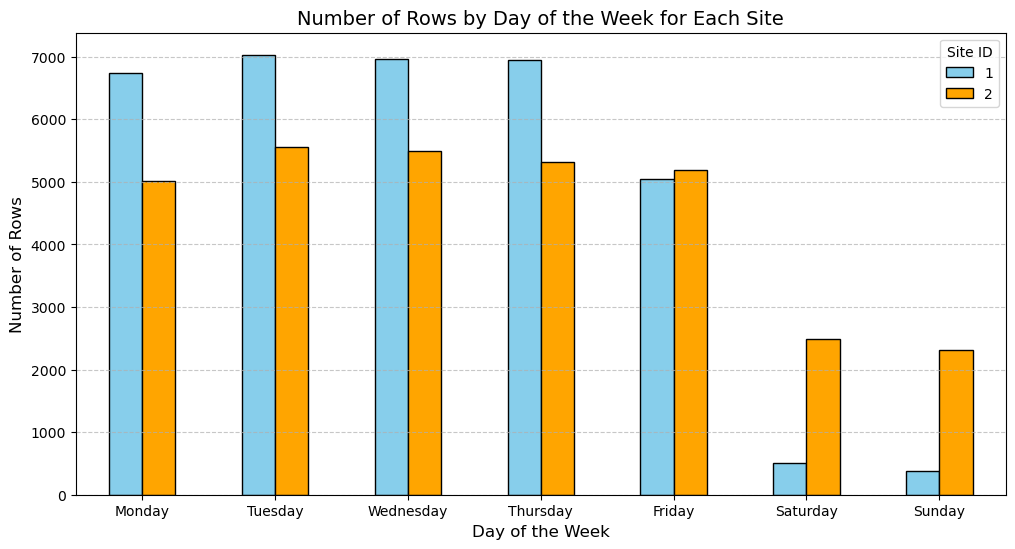

In [77]:
weekly_site_counts = df.groupby(['dayOfWeek', 'siteID'], observed=True).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
weekly_site_counts.plot(kind='bar', figsize=(12, 6), color=['skyblue', 'orange'], edgecolor='black')
plt.title('Number of Rows by Day of the Week for Each Site', fontsize=14)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Number of Rows', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Site ID')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

We see that Site 2 is used **a lot more on the weekend** than Site 1. Since we know that one of the sites is private and only open to employees of a company, we expect the private site to have very few chargings on Saturday and Sunday since most employees do not work on weekends and would thus not charge their car at that site. Therefore, we can conclude that Site 1 is most likely the private one, and Site 2 is most likely the public one since it still has a fairly large number of chargings even on the weekend.

Besides this, we can also look at the **userID**:

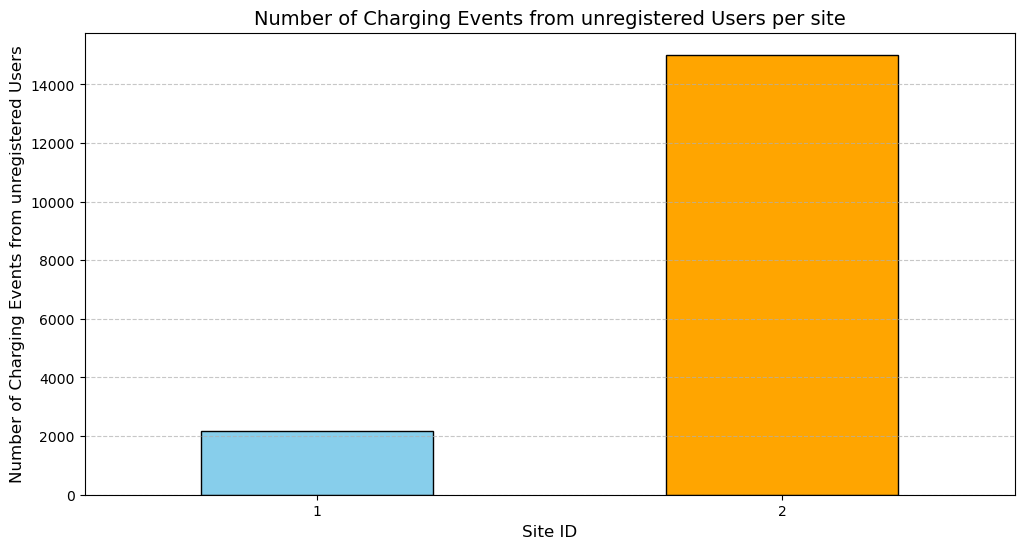

In [78]:
df_unregistered = df[pd.isna(df['userID'])]
site_counts = df_unregistered['siteID'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
site_counts.plot(kind='bar', figsize=(12, 6), color=['skyblue', 'orange'], edgecolor='black')
plt.title('Number of Charging Events from unregistered Users per site', fontsize=14)
plt.xlabel('Site ID', fontsize=12)
plt.ylabel('Number of Charging Events from unregistered Users', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

We see that Site 2 has a lot more chargings from **unregistered** users. We expect the private companies site to have less different users (it should be mostly the same users every day), so this also hints at the Site 1 being the private one and Site 2 the public one.